Analysis of CO2 Emissions from Fuel Sources

This notebook explores CO2 emissions trends by fuel source, focusing on natural gas emissions and their environmental impact. The analysis includes data preprocessing, visualization, and forecasting using time series models.

Import Required Libraries

We will import the necessary libraries for data manipulation, visualization, and time series analysis.

In [219]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install pmdarima
!pip install statsmodels
!pip install scikit-learn

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
from pmdarima import auto_arima
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error

Initial Exploration of Data

We will read the dataset and perform an initial exploration to understand its structure and content.

In [222]:
data = pd.read_csv('CO2_T12_06.csv')
data.head()
data.tail()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSN           5094 non-null   object
 1   YYYYMM        5094 non-null   int64 
 2   Value         5094 non-null   object
 3   Column_Order  5094 non-null   int64 
 4   Description   5094 non-null   object
 5   Unit          5094 non-null   object
dtypes: int64(2), object(4)
memory usage: 238.9+ KB


Data Overview:<br>
- No missing values are present based on initial exploration.<br>
- The `Value` column is in string format and needs to be converted to numeric for analysis.

In [223]:
data.describe()
data.describe(include='O')

,MSN,Value,Description,Unit
count,5094,5094,5094,5094
unique,9,3602,9,1
top,CLEIEUS,Not Available,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
freq,566,416,566,5094


Preprocessing Steps:<br>
Let's ensure all data is numeric and time series formatted, then remove any rows with conversion issues.<br>
Converting 'Value' to a numeric type, and handling dates

In [224]:
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')
data['YYYYMM'] = pd.to_datetime(data['YYYYMM'], format='%Y%m', errors='coerce')
data = data.dropna()

Key Question 1:<br>
What fuel sources contribute the most to CO2 emissions, and how do emissions trends change over time?

In [225]:
def plot_emissions_by_fuel(data):
    """
    Plots CO2 emissions trends by fuel type over time.
    Parameters:
    - data (pd.DataFrame): Dataset to plot.
    Returns:
    - None, displays a plot.
    """
    fuels = data.groupby('Description')
    fig, ax = plt.subplots(figsize=(14,8))
    for desc, group in fuels:
        ax.plot(group['YYYYMM'], group['Value'], label=desc)
    ax.set_title('CO2 Emissions by Fuel Type')
    ax.set_xlabel('Date')
    ax.set_ylabel('Emissions (Value)')
    plt.legend()
    plt.show()

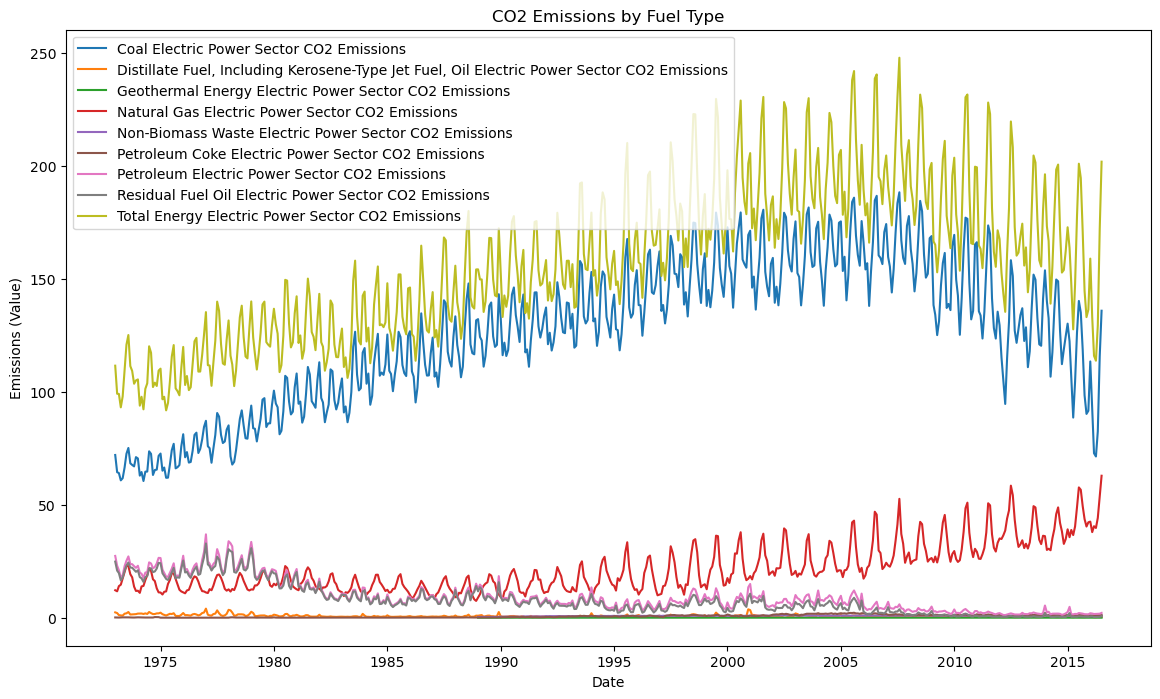

In [226]:
plot_emissions_by_fuel(data)

Summing emissions by fuel type

In [227]:
total_emissions_by_fuel = data.groupby('Description')['Value'].sum()
total_emissions_by_fuel

Description
Coal Electric Power Sector CO2 Emissions                                                      65782.393
Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions      404.887
Geothermal Energy Electric Power Sector CO2 Emissions                                            10.563
Natural Gas Electric Power Sector CO2 Emissions                                               11295.359
Non-Biomass Waste Electric Power Sector CO2 Emissions                                           281.367
Petroleum Coke Electric Power Sector CO2 Emissions                                              338.785
Petroleum Electric Power Sector CO2 Emissions                                                  4982.993
Residual Fuel Oil Electric Power Sector CO2 Emissions                                          4239.312
Total Energy Electric Power Sector CO2 Emissions                                              82352.676
Name: Value, dtype: float64

In [246]:
def plot_total_emissions(emissions_summary):
    """
    Plots total CO2 emissions by fuel type as a bar chart.
    Parameters:
    - emissions_summary (pd.Series): Total emissions for each fuel type.
    Returns:
    - None, displays a bar plot.
    """
    plt.figure(figsize=(10,6))
    emissions_summary.plot(kind='bar', color='teal', title='Total CO2 Emissions by Fuel')
    plt.ylabel("Total Emissions")
    plt.xticks(rotation="vertical")
    plt.show()

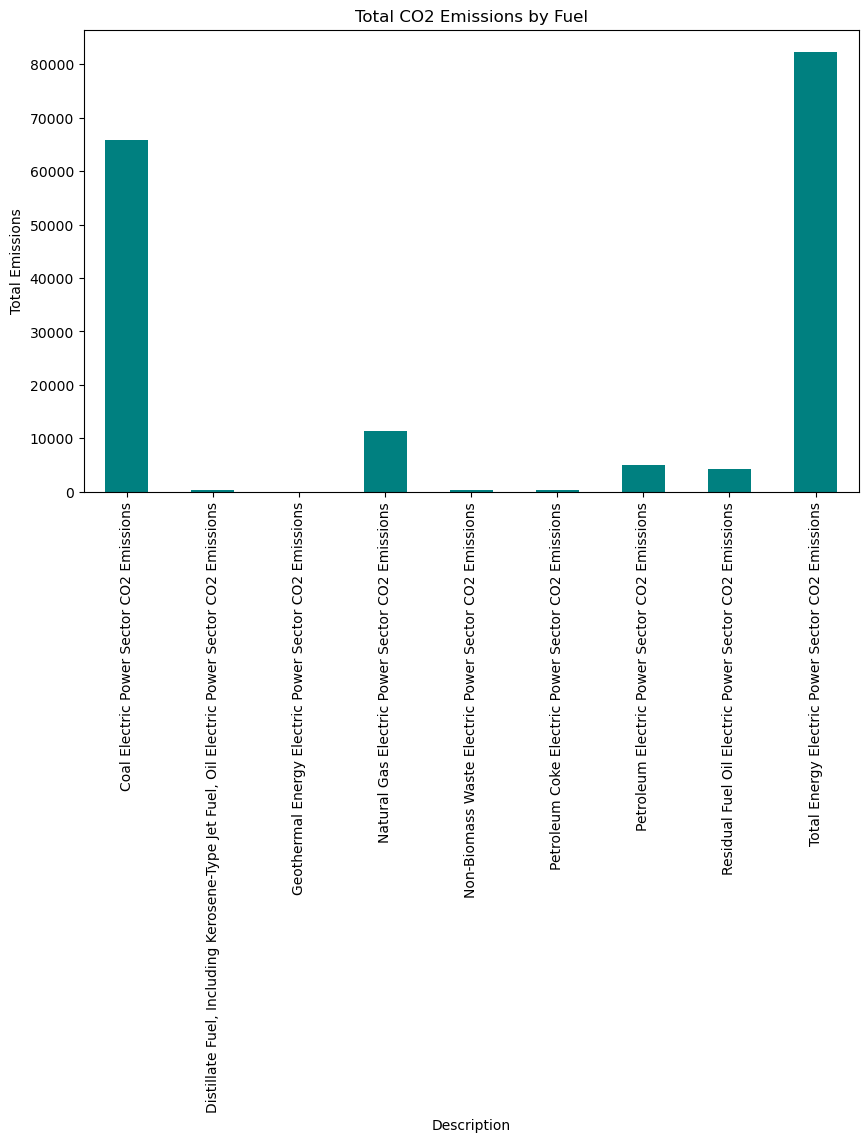

In [247]:
plot_total_emissions(total_emissions_by_fuel)

Answer to Question 1:<br>
Based on the charts, `coal` and `natural gas` are the most significant contributors to CO2 emissions. These trends likely result from their widespread use in power generation and industry.

Converting Data to Time Series Format

In [230]:
ts_data = data.set_index('YYYYMM')
ts_data.head()

,MSN,Value,Column_Order,Description,Unit
YYYYMM,,,,,
1973-01-01,CLEIEUS,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-02-01,CLEIEUS,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-03-01,CLEIEUS,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-04-01,CLEIEUS,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-05-01,CLEIEUS,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


Seasonal Decomposition of Emissions<br>
We will investigate the seasonal patterns in CO2 emissions over time.<br>
Grouping emissions data by month and fuel type

In [231]:
monthly_emissions = ts_data.groupby([pd.Grouper(freq='M'), 'Description'])['Value'].sum().unstack(level=1)
monthly_emissions.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8916\2032775092.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_emissions = ts_data.groupby([pd.Grouper(freq='M'), 'Description'])['Value'].sum().unstack(level=1)


Description,Coal Electric Power Sector CO2 Emissions,"Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions",Geothermal Energy Electric Power Sector CO2 Emissions,Natural Gas Electric Power Sector CO2 Emissions,Non-Biomass Waste Electric Power Sector CO2 Emissions,Petroleum Coke Electric Power Sector CO2 Emissions,Petroleum Electric Power Sector CO2 Emissions,Residual Fuel Oil Electric Power Sector CO2 Emissions,Total Energy Electric Power Sector CO2 Emissions
YYYYMM,,,,,,,,,
1973-01-31,72.076,2.375,NaN,12.175,NaN,0.128,27.369,24.867,111.621
1973-02-28,64.442,2.061,NaN,11.708,NaN,0.106,23.034,20.867,99.185
1973-03-31,64.084,1.171,NaN,13.994,NaN,0.083,21.034,19.780,99.112
1973-04-30,60.842,1.022,NaN,14.627,NaN,0.130,17.714,16.562,93.183
1973-05-31,61.798,0.949,NaN,17.344,NaN,0.167,18.870,17.754,98.012


Question 2:<br>
Investigate the role of natural gas in CO2 emissions and its environmental impact.<br>
Extracting natural gas emissions for analysis

In [232]:
natgas_emissions = monthly_emissions['Natural Gas Electric Power Sector CO2 Emissions']

Seasonal decomposition

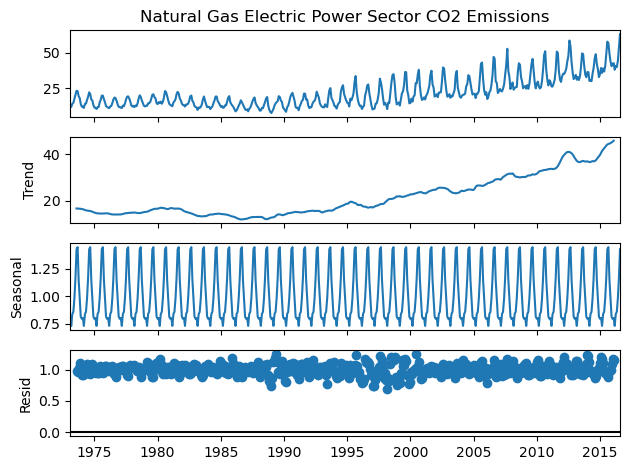

In [233]:
decomposed = seasonal_decompose(natgas_emissions, model='multiplicative', period=12)
decomposed.plot()
plt.show()

Analysis Summary:<br>
- The decomposition reveals a clear trend, seasonal patterns, and residual components for natural gas emissions, suggesting periodic fluctuations with an overall increase in emissions.

Model Building and Forecasting<br>
We will build a forecasting model to predict future natural gas emissions.

Splitting data into train and test sets for model training

In [234]:
train_data = natgas_emissions['1973':'2014']
test_data = natgas_emissions['2015':]

In [235]:
# Extracting natural gas emissions for analysis as a DataFrame
natgas_emissions = monthly_emissions[['Natural Gas Electric Power Sector CO2 Emissions']]
natgas_emissions.columns = ['Value']  # Renaming for consistency

# Splitting data into train and test sets for model training
train_data = natgas_emissions['1973':'2014']
test_data = natgas_emissions['2015':]
test_data = test_data.reset_index()  # Reset index to get YYYYMM as a column

Configuring the ARIMA model with optimal parameters

In [236]:
model = auto_arima(train_data, start_p=1, start_q=1, max_p=4, max_q=4, seasonal=True, m=12, 
                   d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1973.678, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2245.133, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2104.643, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2016.563, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1971.873, Time=0.32 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1973.655, Time=0.75 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2052.695, Time=0.31 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1975.576, Time=1.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2026.056, Time=0.16 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1973.743, Time=0.58 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1973.717, Time=0.64 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2040.781, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1996.323, Time=0.23 sec
 ARIMA(2,1,0)(0,1,1)[12]

In [237]:
print("Model AIC:", model.aic())

Model AIC: 1971.8734176832468


Fitting the model to training data

In [238]:
model.fit(train_data)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

Making Forecasts<br>
Now we will make forecasts based on the fitted model.<br>
Forecasting for the test period

In [239]:
forecast_values = model.predict(n_periods=len(test_data))

Comparing forecasted and actual values

In [240]:
forecast_values = forecast_values.reset_index(drop=True)
test_data['Forecast'] = forecast_values
print(test_data['Forecast'])

0     35.606120
1     32.305101
2     33.381577
3     33.381319
4     37.369740
5     43.052805
6     52.101755
7     52.784773
8     43.264746
9     37.803686
10    33.669208
11    36.191427
12    36.894082
13    33.525690
14    34.558295
15    34.529470
16    38.499290
17    44.170241
18    53.211304
Name: Forecast, dtype: float64


Plotting actual vs forecasted values

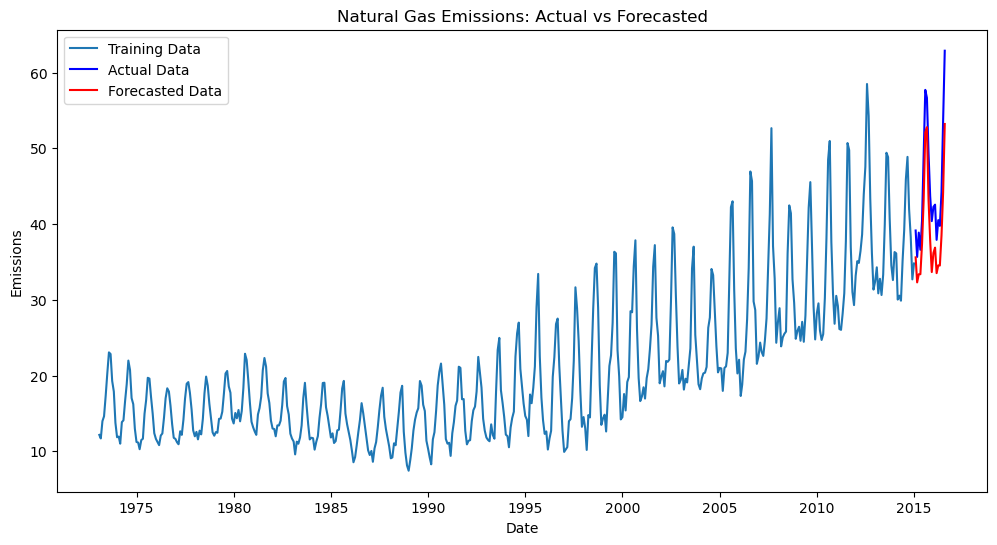

In [241]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Value'], label='Training Data')  # Use index for train_data
plt.plot(test_data['YYYYMM'], test_data['Value'], label='Actual Data', color='blue')
plt.plot(test_data['YYYYMM'], test_data['Forecast'], label='Forecasted Data', color='red')
plt.title("Natural Gas Emissions: Actual vs Forecasted")
plt.xlabel("Date")
plt.ylabel("Emissions")
plt.legend()
plt.show()

Calculating mean absolute error for model evaluation

In [242]:
print(len(test_data['Value']), len(test_data['Forecast']))

19 19


In [243]:
# Calculating mean absolute error for model evaluation
mae_value = mean_absolute_error(test_data['Value'], test_data['Forecast'])
print(f"Mean Absolute Error: {mae_value}")

Mean Absolute Error: 5.520861682233588
